In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from joblib import dump

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%cd /content/drive/My Drive/ShouldWeSurrender15

/content/drive/My Drive/ShouldWeSurrender15


In [4]:
data = pd.read_csv('datasets/high_diamond_ranked_10min.csv')
data_expanded = pd.read_csv('datasets/high_diamond_ranked_10min_with_added_features.csv')

In [ ]:
data.head(5)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [ ]:
data_expanded.columns

Index(['Unnamed: 0', 'Blue_champ_1', 'Blue_champ_2', 'Blue_champ_3',
       'Blue_champ_4', 'Blue_champ_5', 'Red_champ_1', 'Red_champ_2',
       'Red_champ_3', 'Red_champ_4', 'Red_champ_5', 'blueAssists',
       'blueAvgLevel', 'blueCSPerMin', 'blueDeaths', 'blueDragons',
       'blueEliteMonsters', 'blueExperienceDiff', 'blueFirstBlood',
       'blueGoldDiff', 'blueGoldPerMin', 'blueHeralds', 'blueKills',
       'blueTotalExperience', 'blueTotalGold', 'blueTotalJungleMinionsKilled',
       'blueTotalMinionsKilled', 'blueTowersDestroyed', 'blueWardsDestroyed',
       'blueWardsPlaced', 'blueWins', 'gameId', 'lowest_lvl_blue',
       'lowest_lvl_red', 'redAssists', 'redAvgLevel', 'redCSPerMin',
       'redDeaths', 'redDragons', 'redEliteMonsters', 'redExperienceDiff',
       'redFirstBlood', 'redGoldDiff', 'redGoldPerMin', 'redHeralds',
       'redKills', 'redTotalExperience', 'redTotalGold',
       'redTotalJungleMinionsKilled', 'redTotalMinionsKilled',
       'redTowersDestroyed', 're

Some columns in our dataset dont provide additional information(e.g. 'redDeaths' = 'blueKills' so i will delete them)  

In [ ]:
cols = ['blueFirstBlood','blueKills','blueDeaths','blueAssists','blueEliteMonsters',
        'blueDragons','blueTotalGold','blueTotalExperience','blueGoldDiff', 'blueExperienceDiff' ,'blueWins']
cols2 = cols + ['Blue_champ_1', 'Blue_champ_2', 'Blue_champ_3',
       'Blue_champ_4', 'Blue_champ_5', 'Red_champ_1', 'Red_champ_2',
       'Red_champ_3', 'Red_champ_4', 'Red_champ_5','lowest_lvl_blue',
       'lowest_lvl_red']
cleaned_df = data[cols]
cleaned_expanded = data_expanded[cols2]

In [ ]:
cleaned_df.describe()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueGoldDiff,blueExperienceDiff,blueWins
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,16503.455512,17928.110133,14.414111,-33.620306,0.499038
std,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,1535.446636,1200.523764,2453.349179,1920.370438,0.500024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,10098.000000,-10830.000000,-9333.000000,0.000000
25%,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,15415.500000,17168.000000,-1585.500000,-1290.500000,0.000000
50%,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,16398.000000,17951.000000,14.000000,-28.000000,0.000000
75%,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,17459.000000,18724.000000,1596.000000,1212.000000,1.000000
max,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,23701.000000,22224.000000,11467.000000,8348.000000,1.000000


In [ ]:
cleaned_df.corr() 

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueGoldDiff,blueExperienceDiff,blueWins
blueFirstBlood,1.000000,0.269425,-0.247929,0.229485,0.151603,0.134309,0.312058,0.190365,0.378511,0.240665,0.201769
blueKills,0.269425,1.000000,0.004044,0.813667,0.178540,0.170436,0.888751,0.472155,0.654148,0.583730,0.337358
blueDeaths,-0.247929,0.004044,1.000000,-0.026372,-0.204764,-0.188852,-0.162572,-0.460122,-0.640000,-0.577613,-0.339297
blueAssists,0.229485,0.813667,-0.026372,1.000000,0.149043,0.170873,0.748352,0.303022,0.549761,0.437002,0.276685
blueEliteMonsters,0.151603,0.178540,-0.204764,0.149043,1.000000,0.781039,0.239396,0.232774,0.281464,0.263991,0.221944
blueDragons,0.134309,0.170436,-0.188852,0.170873,0.781039,1.000000,0.186413,0.179083,0.233875,0.211496,0.213768
blueTotalGold,0.312058,0.888751,-0.162572,0.748352,0.239396,0.186413,1.000000,0.676193,0.816803,0.729345,0.417213
blueTotalExperience,0.190365,0.472155,-0.460122,0.303022,0.232774,0.179083,0.676193,1.000000,0.717968,0.800815,0.396141
blueGoldDiff,0.378511,0.654148,-0.640000,0.549761,0.281464,0.233875,0.816803,0.717968,1.000000,0.894729,0.511119
blueExperienceDiff,0.240665,0.583730,-0.577613,0.437002,0.263991,0.211496,0.729345,0.800815,0.894729,1.000000,0.489558


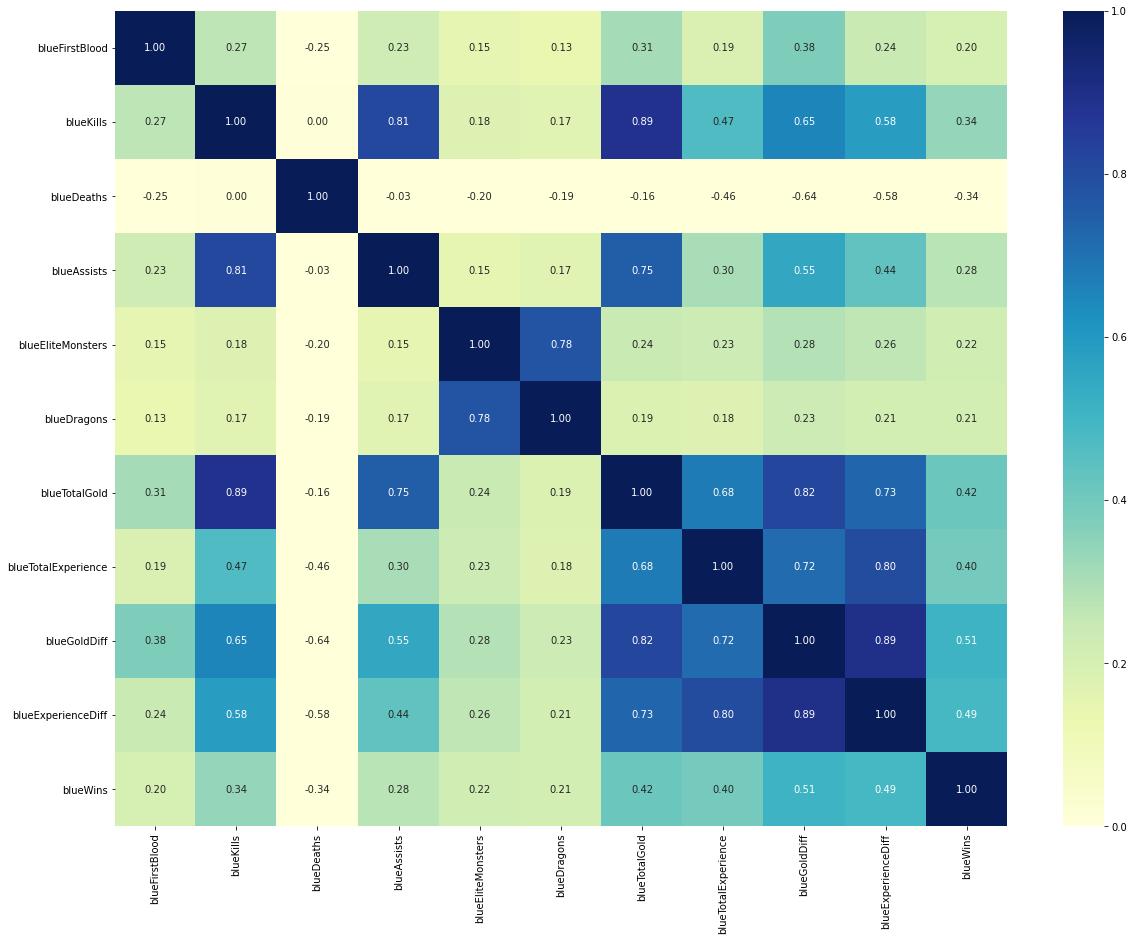

In [ ]:
plt.subplots(figsize=(20,15)) # plotting correlation for overview

sns.heatmap(cleaned_df.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);

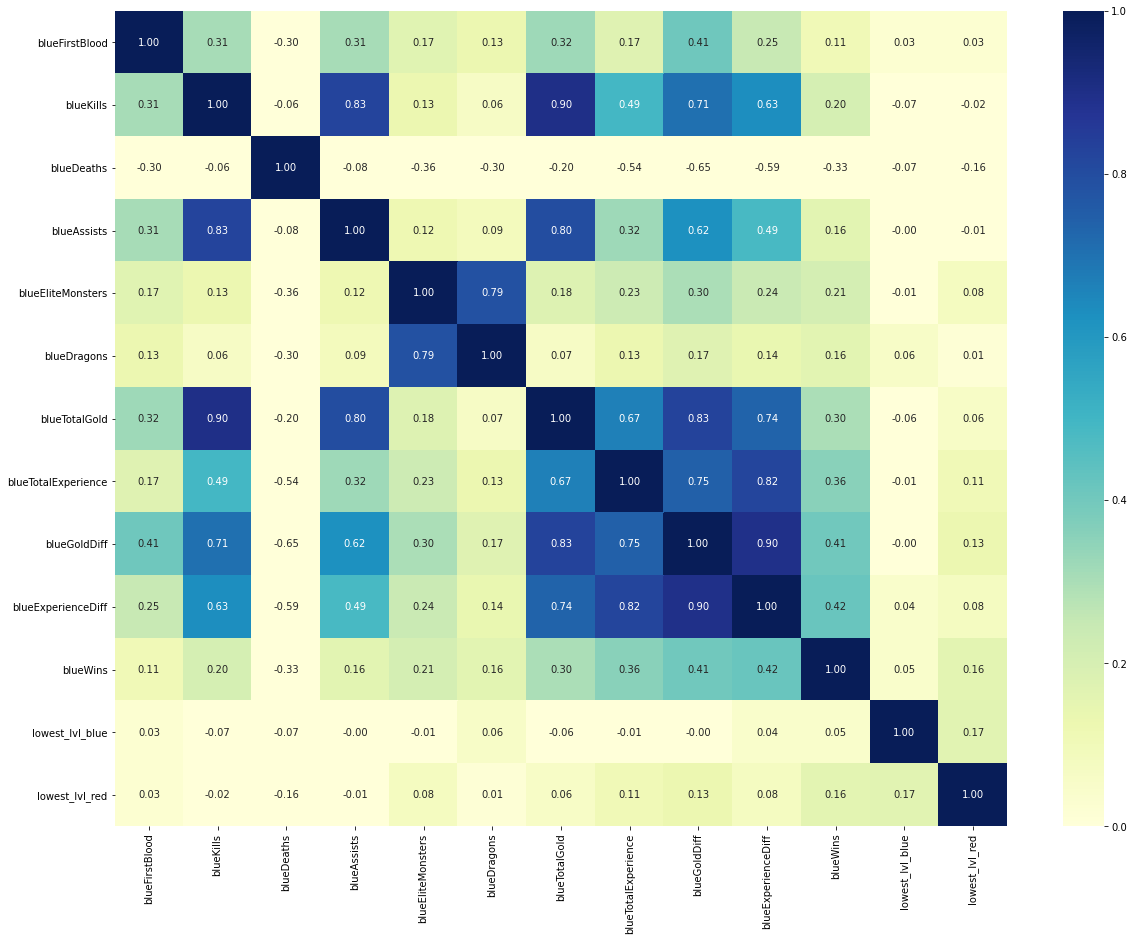

In [ ]:
plt.subplots(figsize=(20,15))
sns.heatmap(cleaned_expanded.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);

In [ ]:
cols2 =['blueGoldDiff','blueExperienceDiff']
cleaned_df[cols2].corr()

,blueGoldDiff,blueExperienceDiff
blueGoldDiff,1.000000,0.898259
blueExperienceDiff,0.898259,1.000000


**As we can see in the correlation table, the highest linear dependency with 'blueWins' column have the 'blueGoldDiff' and 'blueExperienceDiff' columns. Lets now plot the 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1259: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


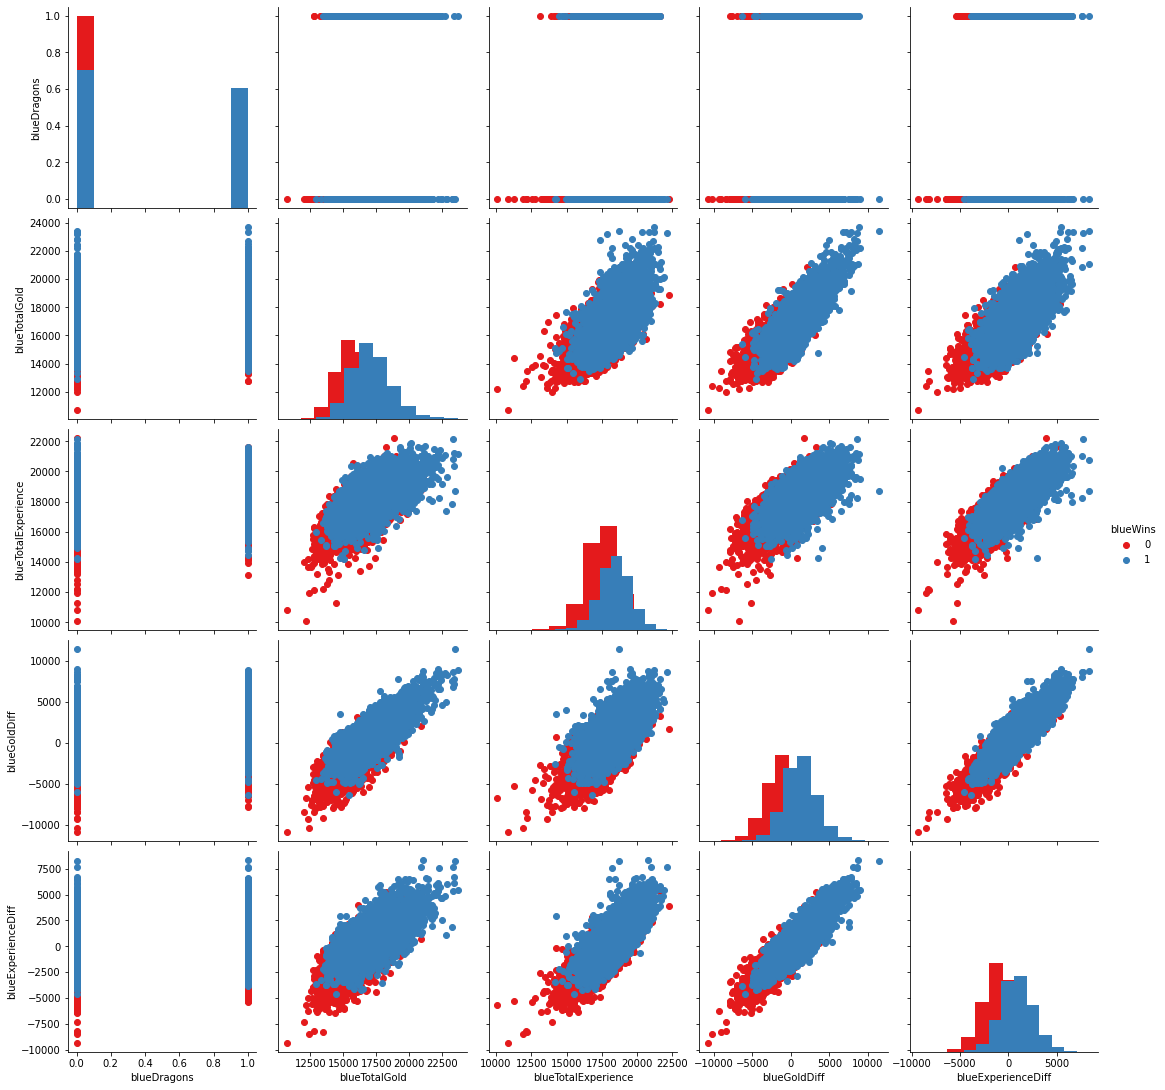

In [ ]:
g = sns.PairGrid(data=cleaned_df, vars = ['blueDragons','blueTotalGold','blueTotalExperience','blueGoldDiff', 'blueExperienceDiff'], hue='blueWins', size=3, palette='Set1')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

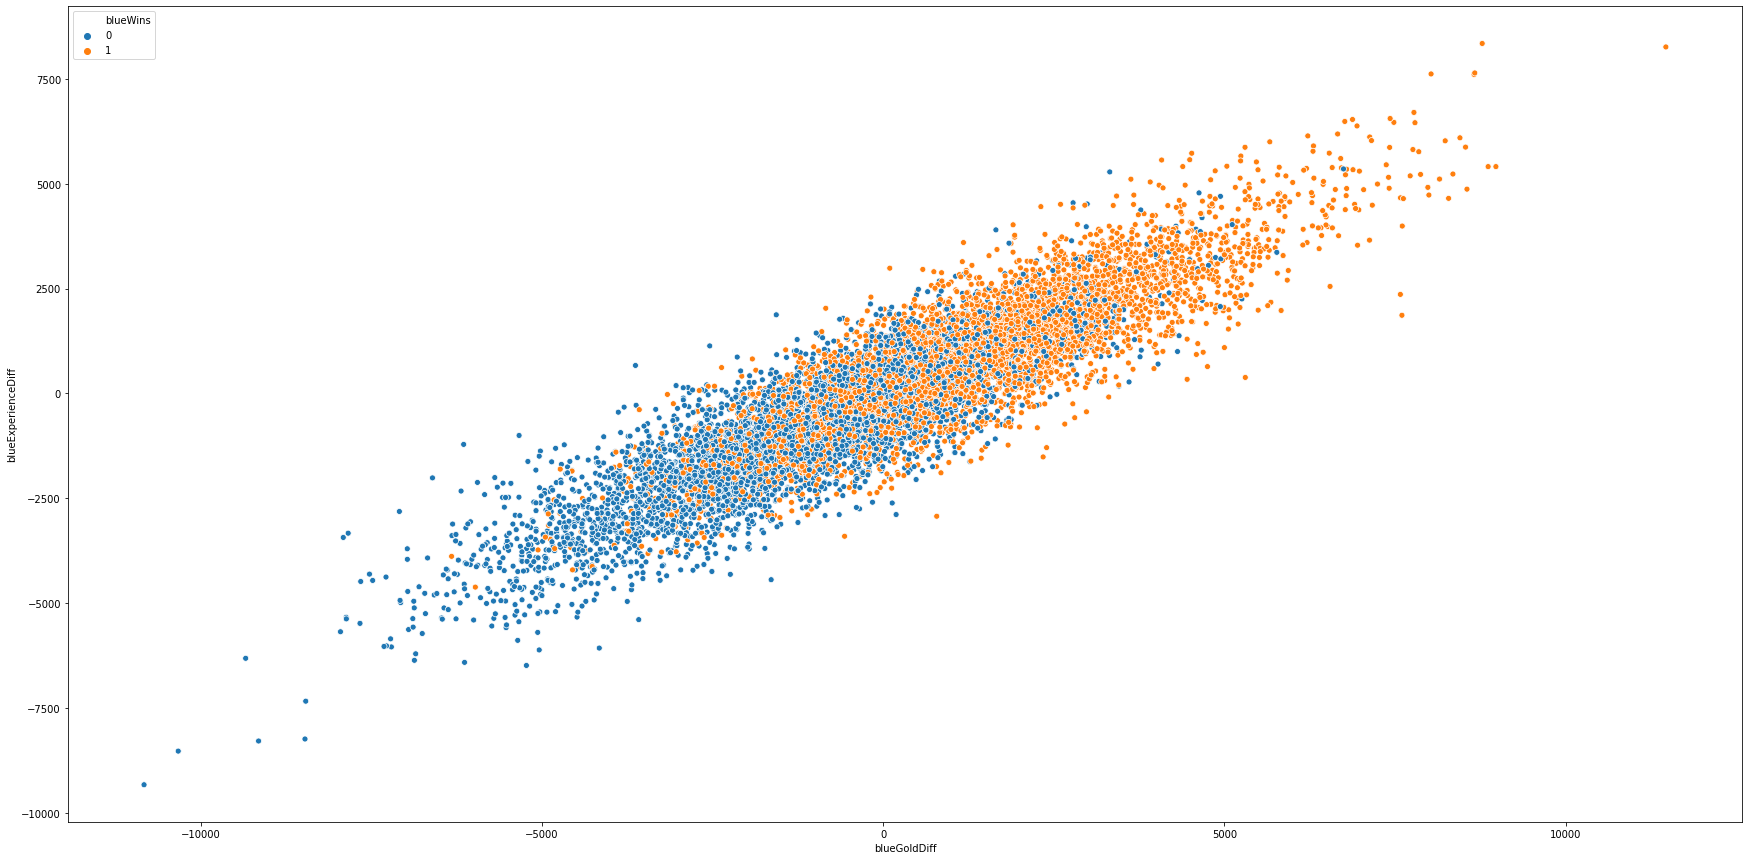

In [ ]:
sns.scatterplot(x = 'blueGoldDiff' , y ='blueExperienceDiff', hue ='blueWins',data = cleaned_df)

As we expected those 2 columns explain most of the variation in the data.
I will use them to train our models and make predictions because at this moment riot games doesnt allow to retrieve data about games in-progress so i want the features to be as easily calculated/estimated by the user as possible.

In [ ]:
Y = cleaned_df['blueWins']
X = cleaned_df[['blueGoldDiff', 'blueExperienceDiff']]

Now lets fit our data to XGboost classifier.

In [ ]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Evaluation using train/test split

In [ ]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 72.00%


Evaluation using 10-fold CV

In [ ]:
kfold = KFold(n_splits=10)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 72.51% (1.24%)


k-fold is generally a better method of evaluation on a small dataset like this since it provides standard deviation and the mean value of the accuracy, as we can see in the example above train/test split probably lowered the true accuracy of the model. Next I plotted a single tree to see what did it take into account while classificating.


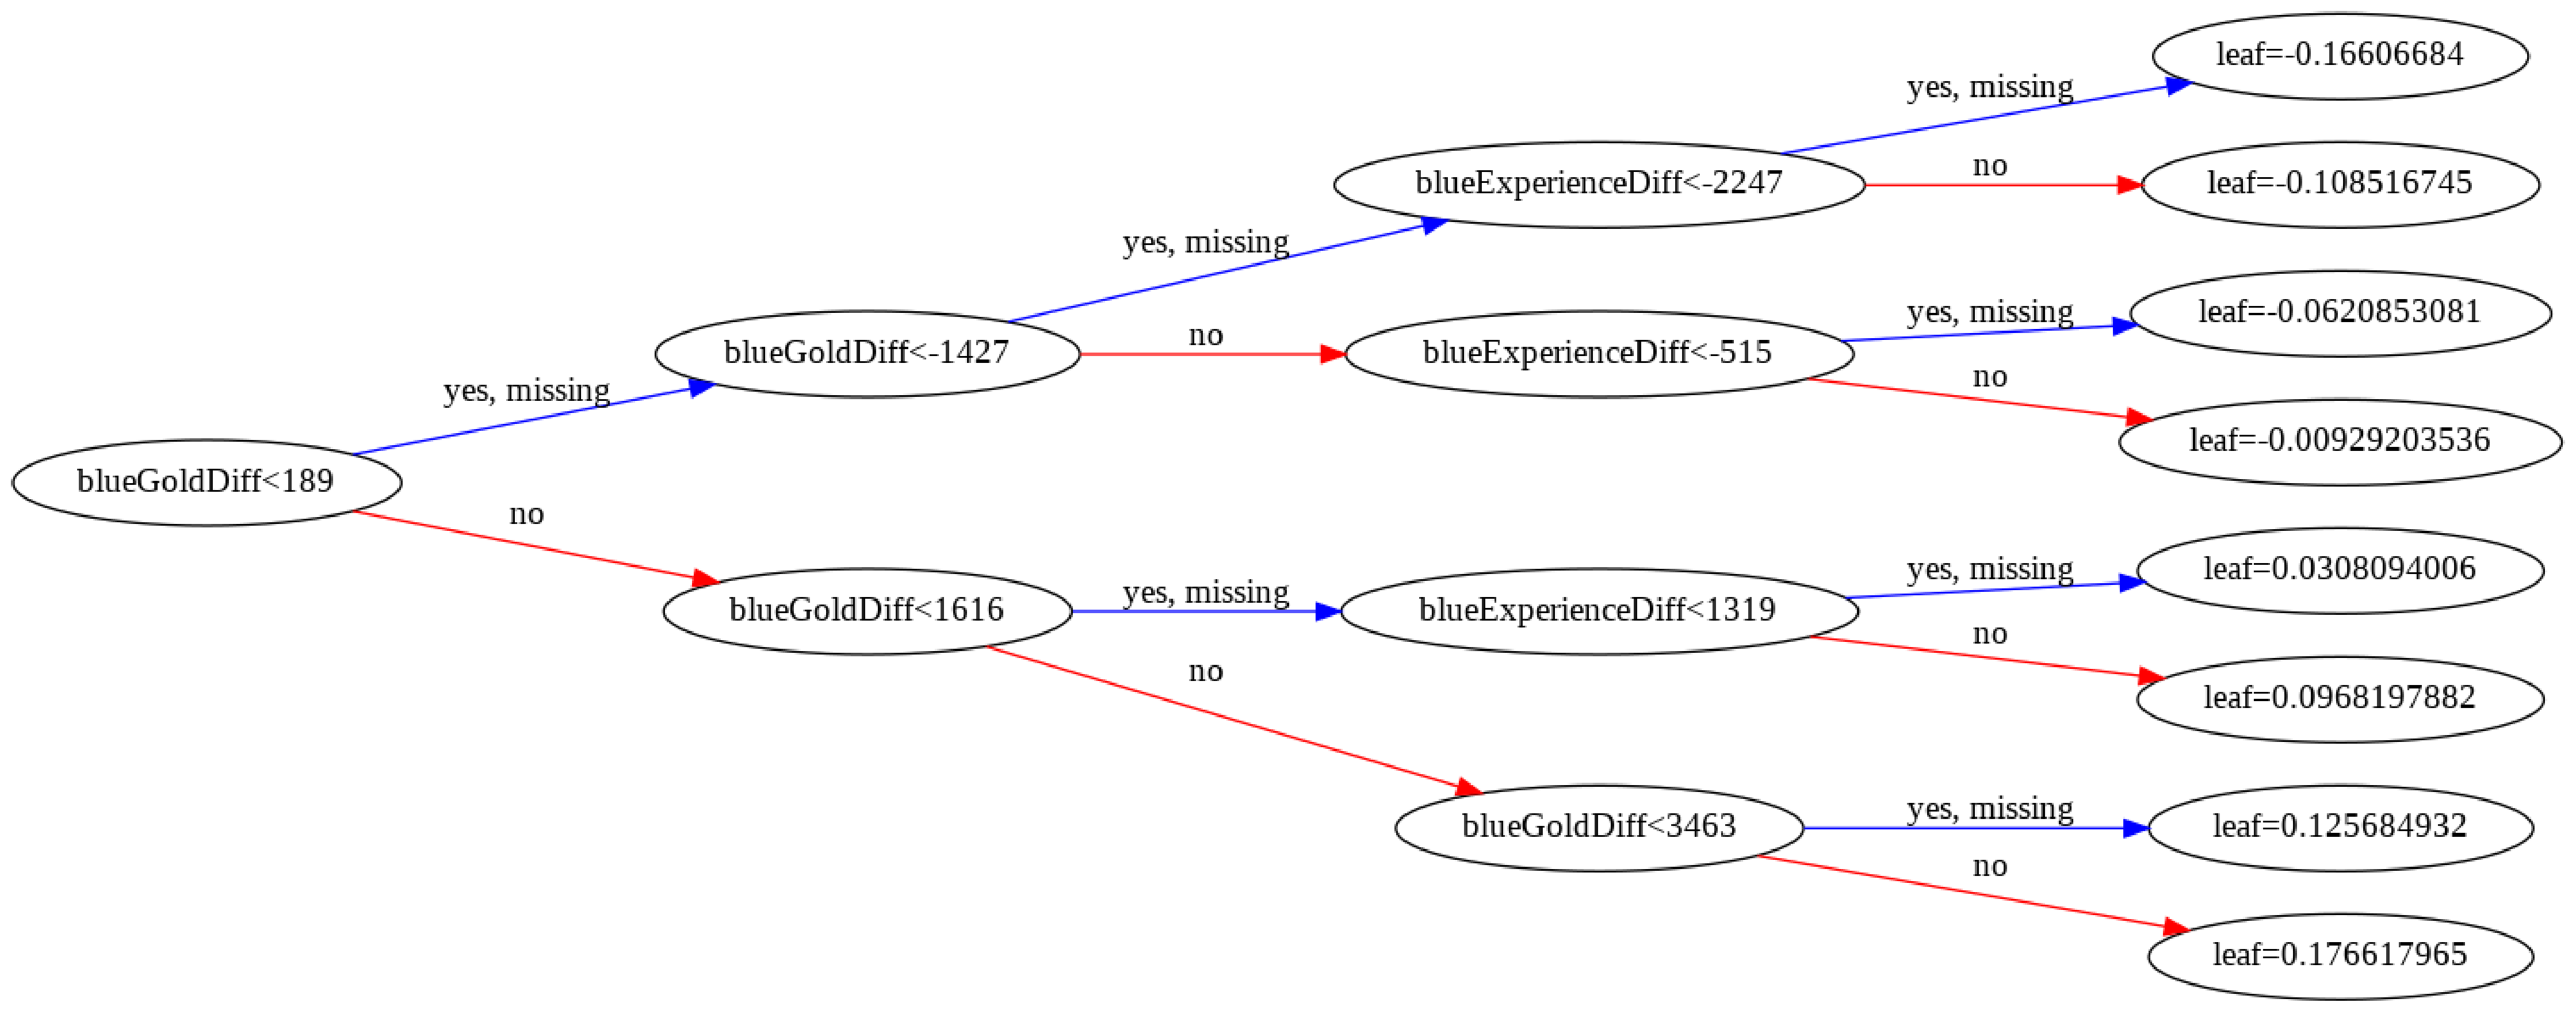

In [ ]:
rcParams['figure.figsize'] = 80,50
plot_tree(model, num_trees=0,rankdir='LR')

Lets check what our model thinks about which features are the most important.

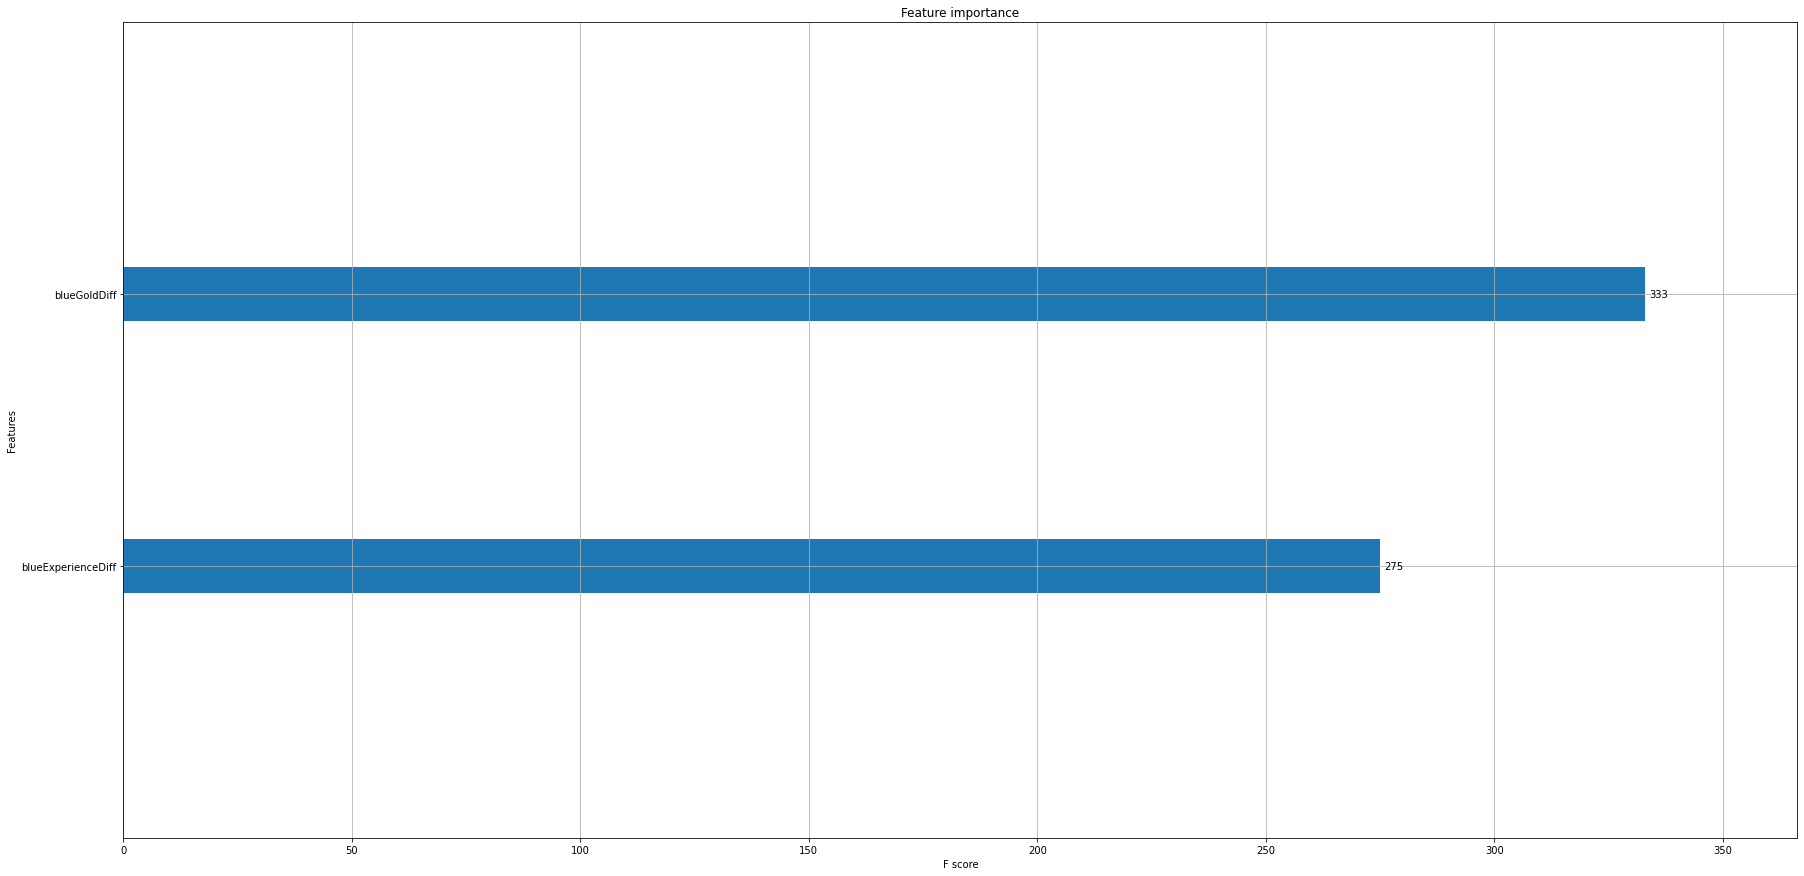

In [ ]:
rcParams['figure.figsize'] = 30,15
plot_importance(model)

Both features are comparably important so ill just stick to them.

Lets create some predictions and make them into probabilities as this is our main goal

In [ ]:
predfeatures = X.sample()
predicts = model.predict_proba(predfeatures)

cols2 = ['probability lose','probability win']
for i,col in enumerate(cols2):
    predfeatures[col] = predicts[:, i]

In [ ]:
predfeatures.head(10)

,blueGoldDiff,blueExperienceDiff,probability lose,probability win
3517,1277,1357,0.26345,0.73655


Possible further improvements of the accuracy:

1.   Team compositions information (scaling/non-scaling composition)
2.   Personal player information (e.g. if any of the players is on lose streak or if any of the players has a winrate > 65% or if he plays his favorite champion)
3.   Model improvement(e.g. pruning, maybe using neural network after getting more data)

Lets now check if our model isnt overfitting.

[0]	validation_0-error:0.274252	validation_0-logloss:0.666504	validation_1-error:0.275376	validation_1-logloss:0.667982
[1]	validation_0-error:0.274252	validation_0-logloss:0.644609	validation_1-error:0.275376	validation_1-logloss:0.647106
[2]	validation_0-error:0.274252	validation_0-logloss:0.626567	validation_1-error:0.275376	validation_1-logloss:0.630061
[3]	validation_0-error:0.274252	validation_0-logloss:0.611377	validation_1-error:0.275376	validation_1-logloss:0.615983
[4]	validation_0-error:0.274252	validation_0-logloss:0.598729	validation_1-error:0.275376	validation_1-logloss:0.604123
[5]	validation_0-error:0.273043	validation_0-logloss:0.588089	validation_1-error:0.271696	validation_1-logloss:0.594303
[6]	validation_0-error:0.268057	validation_0-logloss:0.578953	validation_1-error:0.273229	validation_1-logloss:0.586137
[7]	validation_0-error:0.26715	validation_0-logloss:0.571157	validation_1-error:0.275682	validation_1-logloss:0.579202
[8]	validation_0-error:0.26715	validation

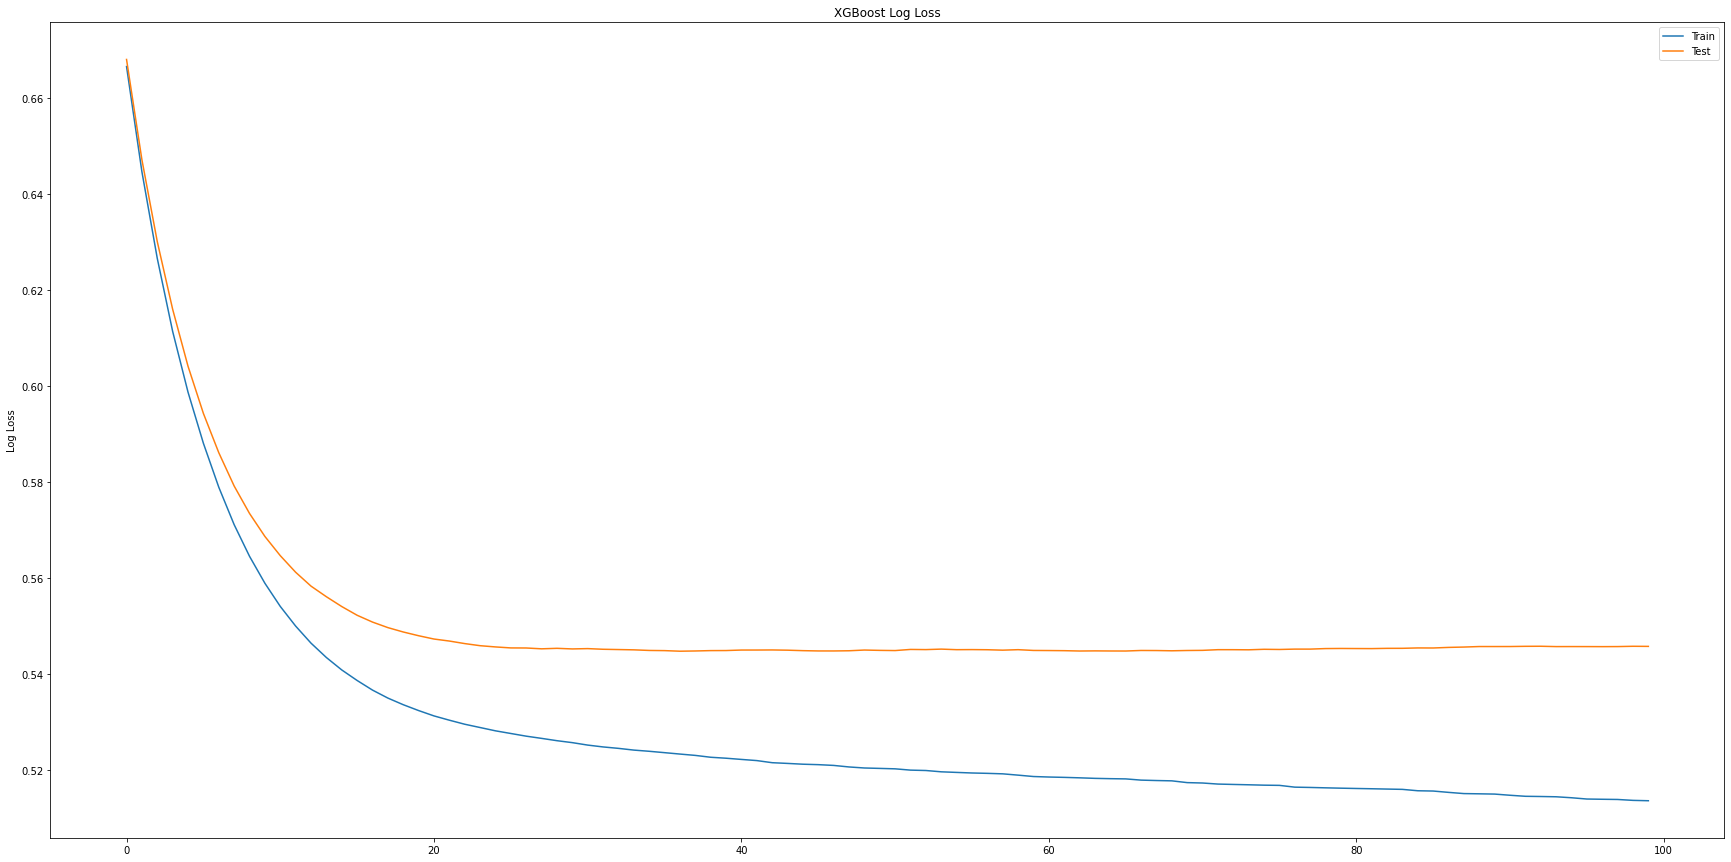

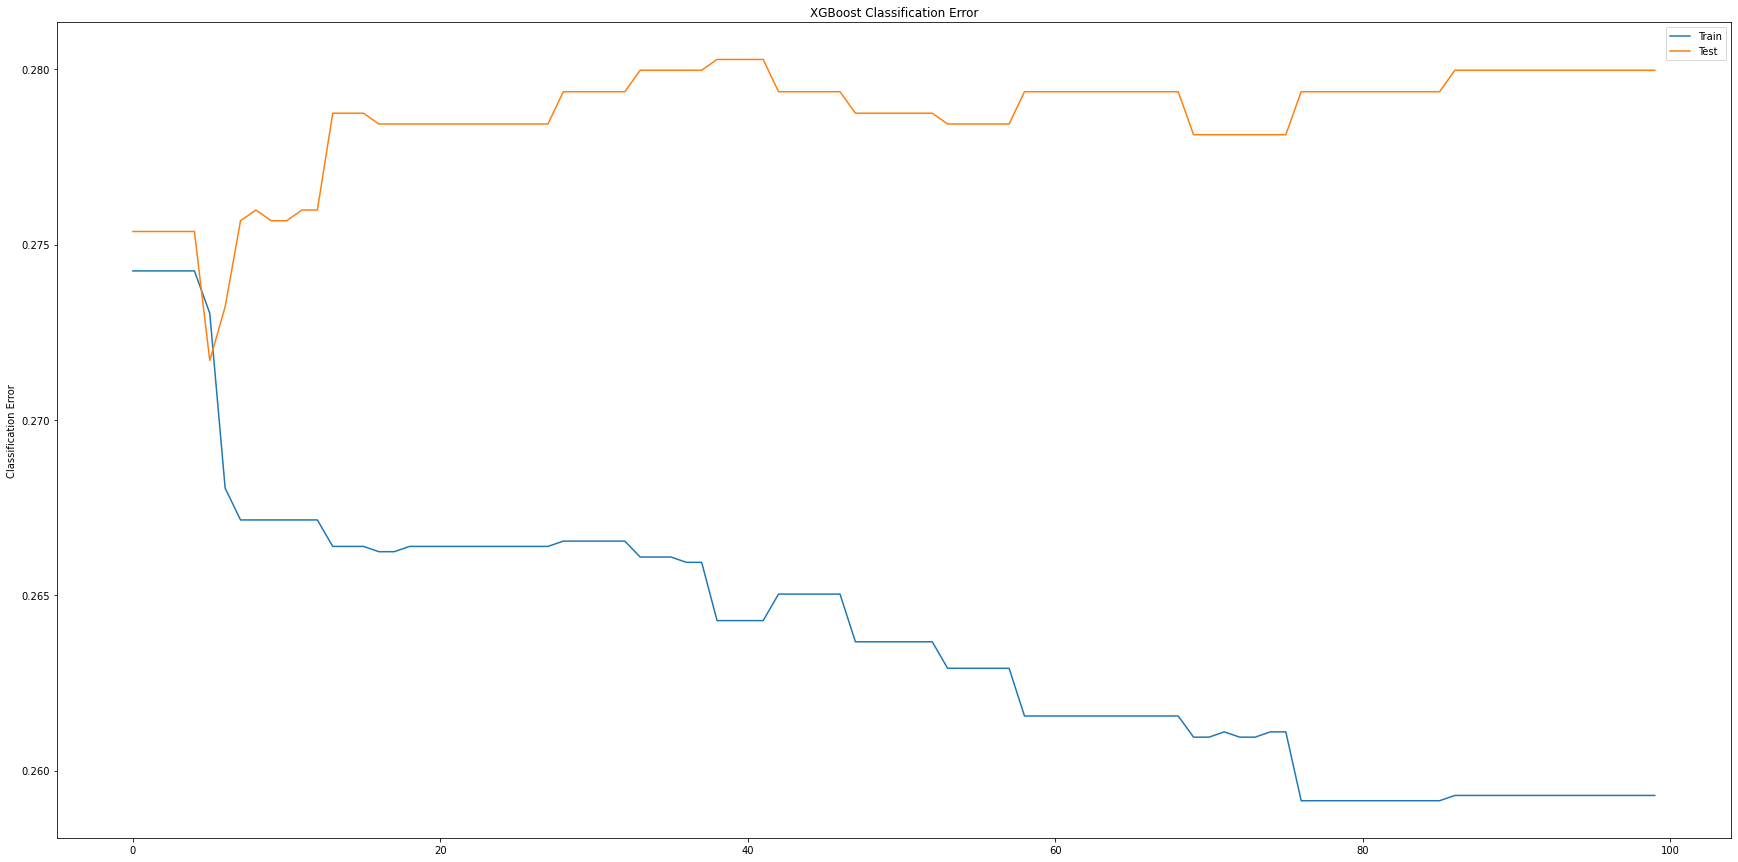

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set,
verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


As we can see our training loss is getting smaller but test acc stays the same and even increases which tells us that we are overfitting our model and maybe we should tweak some learning parameters with GridSearch.


In [ ]:
alg = XGBClassifier(learning_rate=0.05)
clf = GridSearchCV(alg,{'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, 
                    verbose=1, 
                    scoring='neg_log_loss')

clf.fit(X,Y)
clf.best_score_, clf.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   17.8s finished


(-0.5380725893125488, {'max_depth': 2, 'n_estimators': 100})

In [ ]:
final_model = XGBClassifier(learning_rate=0.05, max_depth = 2, n_estimators= 100)

In [ ]:
eval_set = [(X_test, y_test)]
final_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
y_pred = final_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.680743
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.669467
[2]	validation_0-logloss:0.659265
[3]	validation_0-logloss:0.650029
[4]	validation_0-logloss:0.641629
[5]	validation_0-logloss:0.634039
[6]	validation_0-logloss:0.627047
[7]	validation_0-logloss:0.620801
[8]	validation_0-logloss:0.614999
[9]	validation_0-logloss:0.609725
[10]	validation_0-logloss:0.604694
[11]	validation_0-logloss:0.600154
[12]	validation_0-logloss:0.59607
[13]	validation_0-logloss:0.592189
[14]	validation_0-logloss:0.588668
[15]	validation_0-logloss:0.585458
[16]	validation_0-logloss:0.582291
[17]	validation_0-logloss:0.579384
[18]	validation_0-logloss:0.576848
[19]	validation_0-logloss:0.574391
[20]	validation_0-logloss:0.572107
[21]	validation_0-logloss:0.570199
[22]	validation_0-logloss:0.568264
[23]	validation_0-logloss:0.566455
[24]	validation_0-logloss:0.564707
[25]	validation_0-logloss:0.56313
[26]	validation_0-logloss:0.561745

In [ ]:
%cd /content/drive/My Drive/ShouldWeSurrender15

/content/drive/My Drive/ShouldWeSurrender15


In [ ]:
dump(final_model, "model.joblib.dat")
print("Saved model to: model.joblib.dat")

Saved model to: model.joblib.dat


It seems like we can't really get any more accurate predictions with the data we have, so for now lets use this model, and update it once we get the data from points 1 and 2  of our model improvement list.

In [6]:
Y = data['blueWins']
X = data[['redGoldDiff', 'redExperienceDiff']]
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [8]:
final_model_red = XGBClassifier(learning_rate=0.05, max_depth = 2, n_estimators= 100) # analogous model for red team since we dont if eqaul gold diff and equal exp diff result in the same probability for both team
eval_set = [(X_test, y_test)]
final_model_red.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)
y_pred = final_model_red.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.15%


In [ ]:
dump(final_model, "model_red.joblib.dat")
print("Saved model to: model_red.joblib.dat")